In [1]:
import numpy as np
import pandas as pd
import networkx as nx
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from sklearn.metrics import precision_recall_fscore_support
from matplotlib import pyplot as plt
import seaborn as sns 
from xgboost import XGBClassifier
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
import warnings
warnings.filterwarnings("ignore")

In [2]:
evaluation_results_new = []
num_datasets = 1
num_random_splits = 1
for dataset_id in range(num_datasets):
    network_features_df = pd.read_csv('../data/dataframes/links_dfs/' + str(dataset_id) + '/links_df_network_features.csv', index_col=0)
    network_features_df = network_features_df.sample(random_state=dataset_id, frac=1).reset_index(drop=True)
    listening_profile_features_df = pd.read_csv('../data/dataframes/links_dfs/' + str(dataset_id) + '/links_df_listening_profile_features.csv', index_col=0)
    listening_profile_features_df = listening_profile_features_df.sample(random_state=dataset_id, frac=1).reset_index(drop=True)
    listening_characteristics_features_df = pd.read_csv('../data/dataframes/links_dfs/' + str(dataset_id) + '/links_df_listening_characteristics_features.csv', index_col=0)
    listening_characteristics_features_df = listening_characteristics_features_df.drop(columns=["user1_allmusic_weighted_average_diversity",
                                                                                                "user1_allmusic_genre_coverage_diversity",
                                                                                                "user1_allmusic_entropy_diversity",
                                                                                                "user1_user_groups_allmusic_weighted_average_diversity_high",
                                                                                                "user1_user_groups_allmusic_weighted_average_diversity_low",
                                                                                                "user1_user_groups_allmusic_weighted_average_diversity_medium",
                                                                                                "user1_user_groups_allmusic_genre_coverage_diversity_high",
                                                                                                "user1_user_groups_allmusic_genre_coverage_diversity_low",
                                                                                                "user1_user_groups_allmusic_entropy_diversity_high",
                                                                                                "user1_user_groups_allmusic_entropy_diversity_low",
                                                                                                "user1_user_groups_allmusic_entropy_diversity_medium",
                                                                                                "user2_allmusic_weighted_average_diversity",
                                                                                                "user2_allmusic_genre_coverage_diversity",
                                                                                                "user2_allmusic_entropy_diversity",
                                                                                                "user2_user_groups_allmusic_weighted_average_diversity_high",
                                                                                                "user2_user_groups_allmusic_weighted_average_diversity_low",
                                                                                                "user2_user_groups_allmusic_weighted_average_diversity_medium",
                                                                                                "user2_user_groups_allmusic_genre_coverage_diversity_high",
                                                                                                "user2_user_groups_allmusic_genre_coverage_diversity_low",
                                                                                                "user2_user_groups_allmusic_entropy_diversity_high",
                                                                                                "user2_user_groups_allmusic_entropy_diversity_low",
                                                                                                "user2_user_groups_allmusic_entropy_diversity_medium",
                                                                                                "relative_change_allmusic_weighted_average_diversity",
                                                                                                "relative_change_allmusic_genre_coverage_diversity",
                                                                                                "relative_change_allmusic_entropy_diversity",
                                                                                                "same_user_groups_allmusic_weighted_average_diversity",
                                                                                                "same_user_groups_allmusic_genre_coverage_diversity",
                                                                                                "same_user_groups_allmusic_entropy_diversity",
                                                                                                "user1_cnt_listeningevents_lognorm",
                                                                                                "user1_cnt_listeningevents_per_week_lognorm",
                                                                                                "user1_user_groups_cnt_listeningevents_lognorm_high",
                                                                                                "user1_user_groups_cnt_listeningevents_lognorm_low",
                                                                                                "user1_user_groups_cnt_listeningevents_lognorm_medium",
                                                                                                "user1_user_groups_cnt_listeningevents_per_week_lognorm_high",
                                                                                                "user1_user_groups_cnt_listeningevents_per_week_lognorm_low",
                                                                                                "user1_user_groups_cnt_listeningevents_per_week_lognorm_medium",
                                                                                                "user2_cnt_listeningevents_lognorm",
                                                                                                "user2_cnt_listeningevents_per_week_lognorm",
                                                                                                "user2_user_groups_cnt_listeningevents_lognorm_high",
                                                                                                "user2_user_groups_cnt_listeningevents_lognorm_low",
                                                                                                "user2_user_groups_cnt_listeningevents_lognorm_medium",
                                                                                                "user2_user_groups_cnt_listeningevents_per_week_lognorm_high",
                                                                                                "user2_user_groups_cnt_listeningevents_per_week_lognorm_low",
                                                                                                "user2_user_groups_cnt_listeningevents_per_week_lognorm_medium",
                                                                                                "relative_change_cnt_listeningevents_lognorm",
                                                                                                "relative_change_cnt_listeningevents_per_week_lognorm",
                                                                                                "same_user_groups_cnt_listeningevents_lognorm",
                                                                                                "same_user_groups_cnt_listeningevents_per_week_lognorm",
                                                                                                "user1_playcount_lognorm",
                                                                                                "user1_user_groups_playcount_lognorm_high",
                                                                                                "user1_user_groups_playcount_lognorm_low",
                                                                                                "user1_user_groups_playcount_lognorm_medium",
                                                                                                "user2_playcount_lognorm",
                                                                                                "user2_user_groups_playcount_lognorm_high",
                                                                                                "user2_user_groups_playcount_lognorm_low",
                                                                                                "user2_user_groups_playcount_lognorm_medium",
                                                                                                "relative_change_playcount_lognorm",
                                                                                                "same_user_groups_playcount_lognorm"])
    listening_characteristics_features_df = listening_characteristics_features_df.sample(random_state=dataset_id, frac=1).reset_index(drop=True)
    feature_dict = {
        'apf':listening_profile_features_df,
        'mndf':listening_characteristics_features_df,
        'gf':network_features_df
    }
    scores_list = []
    for split_seed in range(num_random_splits):
        for nf in [None, 'gf']:
            for lpf in [None, 'apf']:
                for lcf in [None, 'mndf']:
                    feature_combination = (nf, lpf, lcf)
                    if feature_combination == (None,None,None):
                        continue
                    dfs_to_combine = []
                    for x in (nf, lpf, lcf):
                        if x is not None:
                            dfs_to_combine.append(feature_dict[x])
                    input_df = pd.concat(dfs_to_combine, axis=1)
                    input_df = input_df.loc[:,~input_df.columns.duplicated()]

                    X_train, X_test, y_train, y_test = train_test_split(input_df.drop(columns=['label']), input_df['label'], test_size=0.2, random_state=split_seed)
                    xgb = XGBClassifier(n_estimators=100, use_label_encoder=False, eval_metric='logloss')
                    user_ids_test = pd.DataFrame(X_test[['user1_user_id', 'user2_user_id']])
                    X_train = X_train.drop(columns=['user1_user_id', 'user2_user_id'])
                    X_test = X_test.drop(columns=['user1_user_id', 'user2_user_id'])
                    xgb.fit(X_train, y_train)
                    y_pred = xgb.predict(X_test)
                    predictions = [round(value) for value in y_pred]
                    # evaluate predictions
                    cv = KFold(n_splits=5,shuffle=True)
                    score = cross_val_score(xgb,X_train,y_train,cv=cv)
                    scores_list.append(score)
                    report = classification_report(y_test, predictions)
                    prfs_macro = precision_recall_fscore_support(y_test, predictions, average='macro')
                    prfs_micro = precision_recall_fscore_support(y_test, predictions, average='micro')
                    prfs_weighted = precision_recall_fscore_support(y_test, predictions, average='weighted')
                    feature_importances = sorted(list(zip(xgb.feature_importances_, list(X_train.columns))),  key=lambda x: x[0], reverse=True)
                    evaluation_result = {
                        'dataset_id': dataset_id,
                        'split_seed': split_seed,
                        'network_features': False if nf is None else True,
                        'listening_profile_features': False if lpf is None else True,
                        'listening_characteristics_features': False if lcf is None else True,
                        'report': report,
                        'xgb_feature_importances': feature_importances,
                        'user_ids_test': user_ids_test,
                        'y_test': y_test,
                        'y_pred': y_pred,
                        'prfs_macro': prfs_macro,
                        'prfs_micro': prfs_micro,
                        'prfs_weighted': prfs_weighted,
                        'score':score
                    }
                    evaluation_results_new.append(evaluation_result)
temp = pd.DataFrame(scores_list, columns=['fold-1','fold-2','fold-3','fold-4','fold-5'])
temp.index = ["MNDF","APF","APF+MNDF","GF","GF+MNDF","GF+APF","GF+APF+MNDF"]
temp.to_csv("../data/results/five_fold_scores_XG.csv")

In [3]:
filtered_results = []
for evaluation_result in evaluation_results_new:
    approach_name = ''
    if evaluation_result['network_features']==True:
        if approach_name =='':
            approach_name='GF'
        else:
            approach_name+='+GF'
    if evaluation_result['listening_profile_features']==True:
        if approach_name =='':
            approach_name='APF'
        else:
            approach_name+='+APF'
    if evaluation_result['listening_characteristics_features']==True:
        if approach_name =='':
            approach_name='MNDF'
        else:
            approach_name+='+MNDF'
    filtered_results.append({
        'dataset_id':evaluation_result['dataset_id'],
        'split_seed':evaluation_result['split_seed'],
        'network_features':evaluation_result['network_features'],
        'listening_profile_features':evaluation_result['listening_profile_features'],
        'listening_characteristics_features':evaluation_result['listening_characteristics_features'],
        'accuracy':evaluation_result['report'].split()[15],
        'f_score':evaluation_result['prfs_weighted'][2],
        'precision':evaluation_result['prfs_weighted'][0],
        'recall':evaluation_result['prfs_weighted'][1],
        'score':evaluation_result['score'].mean(),
        'approach_name':approach_name
    })
filtered_results_df = pd.DataFrame(filtered_results)
filtered_results_df.to_csv('../data/results/XG_filtered_results_df.csv')

In [4]:
grouped = filtered_results_df[['approach_name', 'f_score']].groupby(['approach_name'])

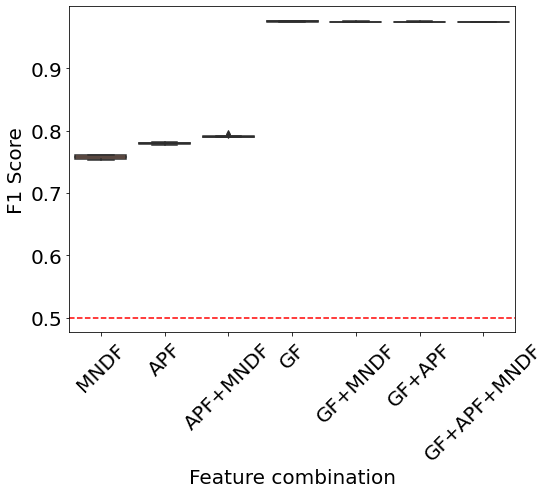

In [5]:
plt.rcParams.update({'figure.figsize' : (8,6)})
plt.rcParams.update({'font.size': 20})
ax = sns.boxplot(palette="flare", x="approach_name", y="f_score", data=filtered_results_df[(filtered_results_df.approach_name=='MNDF')|(filtered_results_df.approach_name=='APF')|(filtered_results_df.approach_name=='APF+MNDF')|(filtered_results_df.approach_name=='GF')|(filtered_results_df.approach_name=='GF+MNDF')|(filtered_results_df.approach_name=='GF+APF')|(filtered_results_df.approach_name=='GF+APF+MNDF')])
ax.set(xlabel='Feature combination', ylabel='F1 Score')
ax.set_xticklabels(ax.get_xticklabels(),rotation=45)
ax.axhline(0.5, ls='--', color='red')
plt.savefig('../figures/link-prediction-results_all.pdf', dpi=300, bbox_inches = "tight")

In [6]:
feature_importances = []
for evaluation_result in evaluation_results_new:
    if evaluation_result['network_features']==False and evaluation_result['listening_profile_features']==True and evaluation_result['listening_characteristics_features']==True:
        tmp = {}
        for entry in evaluation_result['xgb_feature_importances']:
            tmp[entry[1]] = entry[0]
        feature_importances.append(tmp)

In [7]:
feature_importances_df = pd.DataFrame(feature_importances)

In [8]:
nmf_cos = ['cosine_similarity_UAM_nmf_array']
nmf = ['user1_UAM_nmf_10', 'user1_UAM_nmf_18', 'user2_UAM_nmf_10', 'user1_UAM_nmf_5', 'user1_UAM_nmf_16', 'user1_UAM_nmf_4', 'user1_UAM_nmf_6', 'user1_UAM_nmf_11', 'user1_UAM_nmf_13', 'user1_UAM_nmf_15', 'user1_UAM_nmf_2', 'user1_UAM_nmf_19', 'user1_UAM_nmf_1', 'user1_UAM_nmf_14', 'user2_UAM_nmf_16', 'user1_UAM_nmf_3', 'user2_UAM_nmf_13', 'user1_UAM_nmf_0', 'user1_UAM_nmf_9', 'user2_UAM_nmf_9', 'user1_UAM_nmf_7', 'user1_UAM_nmf_12', 'user1_UAM_nmf_8', 'user2_UAM_nmf_5', 'user2_UAM_nmf_17', 'user1_UAM_nmf_17', 'user2_UAM_nmf_6', 'user2_UAM_nmf_15', 'user2_UAM_nmf_12', 'user2_UAM_nmf_1', 'user2_UAM_nmf_4', 'user2_UAM_nmf_18', 'user2_UAM_nmf_19', 'user2_UAM_nmf_0', 'user2_UAM_nmf_7', 'user2_UAM_nmf_2', 'user2_UAM_nmf_8', 'user2_UAM_nmf_3', 'user2_UAM_nmf_14', 'user2_UAM_nmf_11']
mf = ['user1_mainstreaminess_avg_year', 'user1_mainstreaminess_avg_6months', 'user1_mainstreaminess_avg_month', 'user1_mainstreaminess_global', 'user2_mainstreaminess_global', 'user2_mainstreaminess_avg_year', 'user2_mainstreaminess_avg_month', 'user2_mainstreaminess_avg_6months']
mf_rc = ['relative_change_mainstreaminess_avg_month', 'relative_change_mainstreaminess_avg_6months', 'relative_change_mainstreaminess_avg_year', 'relative_change_mainstreaminess_global']
mf_sug = ['same_user_groups_mainstreaminess_avg_month', 'same_user_groups_mainstreaminess_global', 'same_user_groups_mainstreaminess_avg_6months', 'same_user_groups_mainstreaminess_avg_year']
mf_ug = ['user1_user_groups_mainstreaminess_avg_year_medium', 'user2_user_groups_mainstreaminess_global_medium', 'user1_user_groups_mainstreaminess_avg_6months_medium', 'user1_user_groups_mainstreaminess_global_medium', 'user1_user_groups_mainstreaminess_avg_month_medium', 'user2_user_groups_mainstreaminess_avg_month_medium', 'user2_user_groups_mainstreaminess_avg_year_medium', 'user1_user_groups_mainstreaminess_avg_month_high', 'user1_user_groups_mainstreaminess_avg_month_low', 'user1_user_groups_mainstreaminess_avg_6months_high', 'user1_user_groups_mainstreaminess_avg_6months_low', 'user1_user_groups_mainstreaminess_avg_year_high', 'user1_user_groups_mainstreaminess_avg_year_low', 'user1_user_groups_mainstreaminess_global_high', 'user1_user_groups_mainstreaminess_global_low', 'user2_user_groups_mainstreaminess_avg_month_high', 'user2_user_groups_mainstreaminess_avg_month_low', 'user2_user_groups_mainstreaminess_avg_6months_high', 'user2_user_groups_mainstreaminess_avg_6months_low', 'user2_user_groups_mainstreaminess_avg_year_high', 'user2_user_groups_mainstreaminess_avg_year_low', 'user2_user_groups_mainstreaminess_global_high', 'user2_user_groups_mainstreaminess_global_low', 'user2_user_groups_mainstreaminess_avg_6months_medium']
nf = ['user1_novelty_artist_avg_year', 'user1_novelty_artist_avg_6months', 'user2_novelty_artist_avg_year', 'user1_novelty_artist_avg_month', 'user2_novelty_artist_avg_month', 'user2_novelty_artist_avg_6months']
nf_rc = ['relative_change_novelty_artist_avg_6months', 'relative_change_novelty_artist_avg_year', 'relative_change_novelty_artist_avg_month']
nf_sug = ['same_user_groups_novelty_artist_avg_6months', 'same_user_groups_novelty_artist_avg_year', 'same_user_groups_novelty_artist_avg_month']
nf_ug = ['user2_user_groups_novelty_artist_avg_month_medium', 'user1_user_groups_novelty_artist_avg_month_medium', 'user1_user_groups_novelty_artist_avg_year_medium', 'user1_user_groups_novelty_artist_avg_6months_medium', 'user2_user_groups_novelty_artist_avg_6months_medium', 'user2_user_groups_novelty_artist_avg_year_medium', 'user1_user_groups_novelty_artist_avg_month_high', 'user1_user_groups_novelty_artist_avg_month_low', 'user1_user_groups_novelty_artist_avg_6months_high', 'user1_user_groups_novelty_artist_avg_6months_low', 'user1_user_groups_novelty_artist_avg_year_high', 'user1_user_groups_novelty_artist_avg_year_low', 'user2_user_groups_novelty_artist_avg_month_high', 'user2_user_groups_novelty_artist_avg_month_low', 'user2_user_groups_novelty_artist_avg_6months_high', 'user2_user_groups_novelty_artist_avg_6months_low', 'user2_user_groups_novelty_artist_avg_year_high', 'user2_user_groups_novelty_artist_avg_year_low']
df = ['user1_freebase_entropy_diversity', 'user1_freebase_genre_coverage_diversity', 'user1_freebase_weighted_average_diversity', 'user1_cnt_distinct_artists_lognorm', 'user2_freebase_entropy_diversity', 'user2_freebase_genre_coverage_diversity', 'user2_cnt_distinct_artists_lognorm', 'user2_freebase_weighted_average_diversity', 'user1_cnt_distinct_tracks_lognorm', 'user2_cnt_distinct_tracks_lognorm']
df_rc = ['relative_change_freebase_entropy_diversity', 'relative_change_cnt_distinct_artists_lognorm', 'relative_change_freebase_genre_coverage_diversity', 'relative_change_freebase_weighted_average_diversity', 'relative_change_cnt_distinct_tracks_lognorm']
df_sug = ['same_user_groups_freebase_weighted_average_diversity', 'same_user_groups_cnt_distinct_artists_lognorm', 'same_user_groups_freebase_genre_coverage_diversity', 'same_user_groups_freebase_entropy_diversity', 'same_user_groups_cnt_distinct_tracks_lognorm']
df_ug = ['user1_user_groups_freebase_weighted_average_diversity_medium', 'user1_user_groups_freebase_weighted_average_diversity_medium', 'user1_user_groups_freebase_weighted_average_diversity_high', 'user1_user_groups_freebase_weighted_average_diversity_low', 'user1_user_groups_freebase_genre_coverage_diversity_high', 'user1_user_groups_freebase_genre_coverage_diversity_low', 'user1_user_groups_freebase_entropy_diversity_high', 'user1_user_groups_freebase_entropy_diversity_low', 'user2_user_groups_freebase_weighted_average_diversity_high', 'user2_user_groups_freebase_weighted_average_diversity_low', 'user2_user_groups_freebase_genre_coverage_diversity_high', 'user2_user_groups_freebase_genre_coverage_diversity_low', 'user2_user_groups_freebase_entropy_diversity_high', 'user2_user_groups_freebase_entropy_diversity_low', 'user1_user_groups_cnt_distinct_tracks_lognorm_high', 'user1_user_groups_cnt_distinct_tracks_lognorm_low', 'user1_user_groups_cnt_distinct_artists_lognorm_high', 'user1_user_groups_cnt_distinct_artists_lognorm_low', 'user2_user_groups_cnt_distinct_tracks_lognorm_high', 'user2_user_groups_cnt_distinct_tracks_lognorm_low', 'user2_user_groups_cnt_distinct_artists_lognorm_high', 'user2_user_groups_cnt_distinct_artists_lognorm_low', 'user2_user_groups_freebase_entropy_diversity_medium', 'user1_user_groups_freebase_genre_coverage_diversity_medium', 'user2_user_groups_freebase_genre_coverage_diversity_medium', 'user2_user_groups_cnt_distinct_artists_lognorm_medium', 'user1_user_groups_freebase_entropy_diversity_medium', 'user1_user_groups_cnt_distinct_artists_lognorm_medium', 'user2_user_groups_freebase_weighted_average_diversity_medium']

In [9]:
nmf_cos_mean = list(feature_importances_df[nmf_cos].mean().values)

nmf_mean = list(feature_importances_df[nmf].mean().values)

mf_mean = list(feature_importances_df[mf].mean().values)
mf_rc_mean = list(feature_importances_df[mf_rc].mean().values)
mf_sug_mean = list(feature_importances_df[mf_sug].mean().values)
mf_ug_mean = list(feature_importances_df[mf_ug].mean().values)

nf_mean = list(feature_importances_df[nf].mean().values)
nf_rc_mean = list(feature_importances_df[nf_rc].mean().values)
nf_sug_mean = list(feature_importances_df[nf_sug].mean().values)
nf_ug_mean = list(feature_importances_df[nf_ug].mean().values)

df_mean = list(feature_importances_df[df].mean().values)
df_rc_mean = list(feature_importances_df[df_rc].mean().values)
df_sug_mean = list(feature_importances_df[df_sug].mean().values)
df_ug_mean = list(feature_importances_df[df_ug].mean().values)

In [10]:
import itertools
mndf_mean_sum = sum(list(itertools.chain(mf_mean, mf_rc_mean, mf_sug_mean, mf_ug_mean, nf_mean, nf_rc_mean, nf_sug_mean, nf_ug_mean, df_mean, df_rc_mean, df_sug_mean, df_ug_mean)))
apf_mean_sum = sum(list(itertools.chain(nmf_mean, nmf_cos_mean)))
mf_mean_sum = sum(list(itertools.chain(mf_mean, mf_rc_mean, mf_sug_mean, mf_ug_mean)))
nf_mean_sum = sum(list(itertools.chain(nf_mean, nf_rc_mean, nf_sug_mean, nf_ug_mean)))
df_mean_sum = sum(list(itertools.chain(df_mean, df_rc_mean, df_sug_mean, df_ug_mean)))

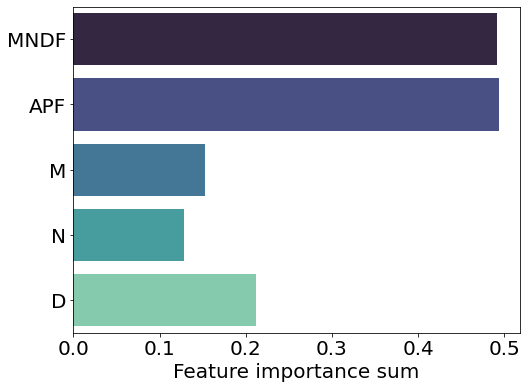

In [11]:
ax = sns.barplot(x=[mndf_mean_sum, apf_mean_sum, mf_mean_sum, nf_mean_sum, df_mean_sum], y=['MNDF', 'APF', 'M', 'N', 'D'], palette='mako')
ax.set(xlabel="Feature importance sum")
plt.savefig('../figures/feature-importance-sum.pdf', dpi=300, bbox_inches = "tight")